In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
dataset_dir = pathlib.Path(dataset_dir).with_suffix('')

228813984/228813984 [==============================] - 1s 0us/step


In [7]:
image_count = len(list(dataset_dir.glob("*/*.jpg")))
print(f"Всего изображений: {image_count}")

Всего изображений: 3670


In [8]:
batch_size = 32
img_width = 180
img_height = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
	dataset_dir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

# cache
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [9]:
# create model
num_classes = len(class_names)
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Epoch 1/10
92/92 [==============================] - 80s 837ms/step - loss: 1.4983 - accuracy: 0.3392 - val_loss: 1.2138 - val_accuracy: 0.5177
Epoch 2/10
92/92 [==============================] - 71s 772ms/step - loss: 1.1230 - accuracy: 0.5589 - val_loss: 1.1093 - val_accuracy: 0.5422
Epoch 3/10
92/92 [==============================] - 71s 770ms/step - loss: 0.9049 - accuracy: 0.6587 - val_loss: 0.9561 - val_accuracy: 0.6199
Epoch 4/10
92/92 [==============================] - 72s 779ms/step - loss: 0.7028 - accuracy: 0.7415 - val_loss: 0.9065 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 71s 774ms/step - loss: 0.4937 - accuracy: 0.8256 - val_loss: 1.0313 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 71s 773ms/step - loss: 0.2978 - accuracy: 0.8948 - val_loss: 1.3106 - val_accuracy: 0.5777
Epoch 7/10
92/92 [==============================] - 71s 778ms/step - loss: 0.1668 - accuracy: 0.9482 - val_loss: 1.4367 - val_accuracy: 0.6185

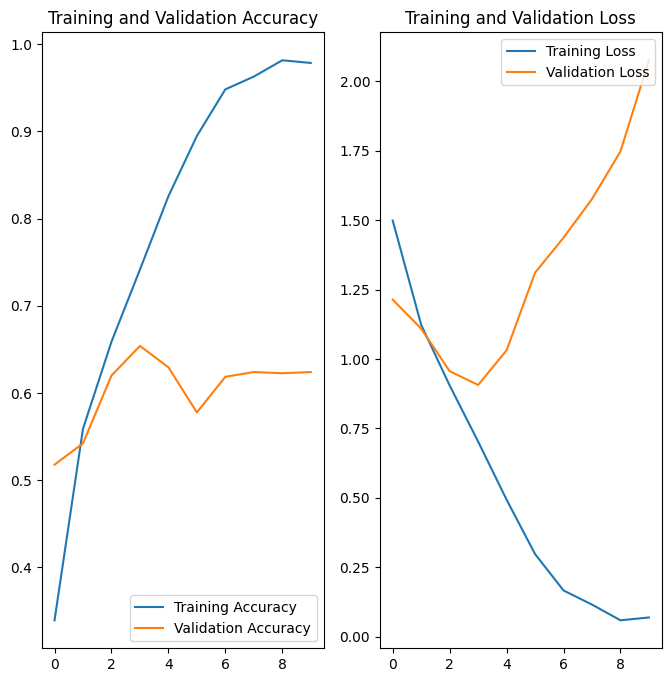

In [10]:
# train the model
epochs = 10 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model = Sequential([
	# т.к. у нас версия TF 2.6 локально
	layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

	# аугментация
	layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
	layers.experimental.preprocessing.RandomRotation(0.1),
	layers.experimental.preprocessing.RandomZoom(0.1),
	layers.experimental.preprocessing.RandomContrast(0.2),

	# дальше везде одинаково
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),

	# регуляризация
	layers.Dropout(0.2),

	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# compile the model
model.compile(
	optimizer='adam',
	loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	metrics=['accuracy'])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCon  (None, 180, 180, 3)       0         
 trast)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)     

In [12]:
# train the model
epochs = 20 # количество эпох тренировки
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs)

# visualize training and validation results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/20
21/92 [=====>........................] - ETA: 1:04 - loss: 1.5919 - accuracy: 0.2693

KeyboardInterrupt: 

In [15]:
# load image
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# make predictions
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print inference result
print("На изображении скорее всего {} ({:.2f}% вероятность)".format(
	class_names[np.argmax(score)],
	100 * np.max(score)))

# show the image itself
img.show()

1/1 [==============================] - 0s 27ms/step
На изображении скорее всего sunflowers (33.55% вероятность)


In [16]:
from google.colab import files

model_file_name = "my_flowers_model.h5"

# save model
model.save(model_file_name)

# download model
files.download(model_file_name)

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>